In [143]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [156]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad 
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data **(other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad 
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [157]:
a = Value(2.0)
b = Value(4.0)
1 + a

Value(data=3.0)

In [147]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [148]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.88123432394673279, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

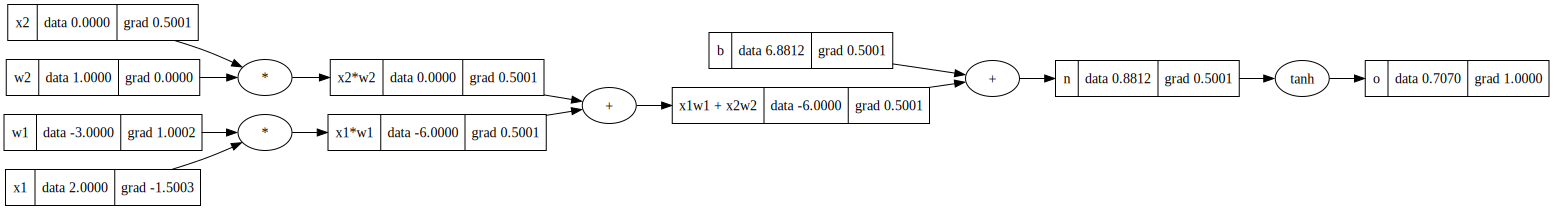

In [149]:
draw_dot(o)

In [150]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.88123432394673279, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()

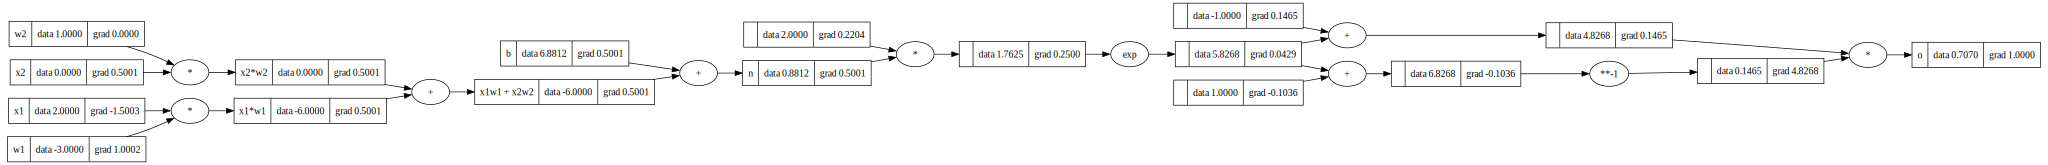

In [151]:
draw_dot(o)

In [210]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w * x + b
       act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
       out = act.tanh()
       return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [341]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.23005556550661221)

In [342]:
n.parameters()

[Value(data=-0.7591141242008315),
 Value(data=0.2542225106674998),
 Value(data=0.7692245831490341),
 Value(data=0.9385091400757815),
 Value(data=0.3075308327251005),
 Value(data=0.9397501437827349),
 Value(data=-0.4232626273723219),
 Value(data=-0.2659766975738216),
 Value(data=0.9703746169313163),
 Value(data=-0.8961108494493266),
 Value(data=0.33512151247665134),
 Value(data=0.6699783303567373),
 Value(data=0.17196259749127596),
 Value(data=0.12150989867570883),
 Value(data=0.9079810067230842),
 Value(data=-0.25381852641235203),
 Value(data=0.8901635838679831),
 Value(data=0.7845458524233677),
 Value(data=0.4861679885045187),
 Value(data=-0.323278022708017),
 Value(data=0.5020813608268173),
 Value(data=-0.5817839601843604),
 Value(data=-0.8832427470481687),
 Value(data=-0.717548212873476),
 Value(data=0.7591453750488253),
 Value(data=0.24660976723479422),
 Value(data=0.4364795014279712),
 Value(data=0.8439397596509801),
 Value(data=-0.29080044212837075),
 Value(data=-0.60943533668430

In [343]:
len(n.parameters())

41

In [344]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [367]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)

0 0.0032509524018846064
1 0.0032129176525276452
2 0.0031757385502570097
3 0.0031393869306196
4 0.0031038358416061074
5 0.003069059479473546
6 0.003035033128584469
7 0.003001733104973642
8 0.002969136703376288
9 0.0029372221474736533
10 0.00290596854313064
11 0.0028753558344186392
12 0.0028453647622323657
13 0.002815976825324396
14 0.0027871742435949766
15 0.002758939923486601
16 0.0027312574253442424
17 0.002704110932612793
18 0.00267748522275253
19 0.002651365639761951


In [368]:
ypred

[Value(data=0.9791186776864399),
 Value(data=-0.9728492469626883),
 Value(data=-0.9723096242564278),
 Value(data=0.9733276225490516)]